In [1]:
import pandas as pd
import numpy as np
import sklearn

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, classification_report

import matplotlib.pyplot as plt
import seaborn as sns
import warnings, os, time

from datetime import datetime, timedelta

warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('../Edu/code/data/diabetes_for_test.csv')

In [3]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


## 1-1 시각화 포함 EDA 시행

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [5]:
df.isna().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [6]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,36.980469,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,61.404453,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,999.000000,1.000000


해당 데이터는 결측값이 존재하지 않으며, 데이터 모두 수치형 변수이다.  
그 중에서도 종속변수인 Outcome 변수는 이진 변수임을 알 수 있다.

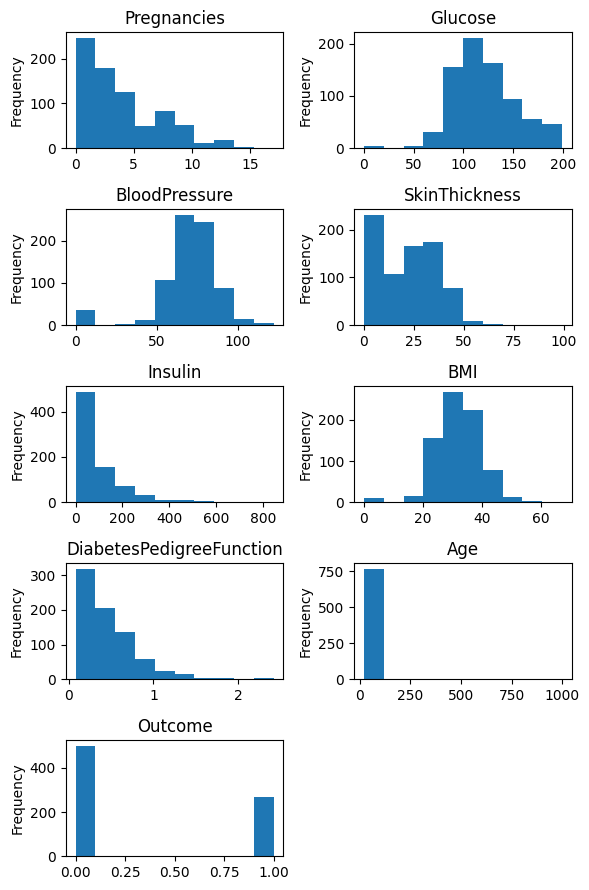

In [7]:
plt.figure(figsize=(6, 9))

for idx, col in enumerate(df.columns):
    plt.subplot(5, 2, idx+1)
    plt.title(col)
    df[col].plot(kind='hist')

plt.tight_layout()
plt.show();

히스토그램을 통해 변수들을 살펴보면  
종속변수 Outcome의 경우 다소 불균형하다고 볼 수 있다.  
Glucose와 BloodPressure, BMI를 제외하면 종 모양의 데이터는 없다.  

때문에 모델 학습 시에 스케일링이 필요해 보이고,  
모델의 성능이 낮다면 종속변수의 불균형 해결이 필요해 보인다.

<Figure size 800x800 with 0 Axes>

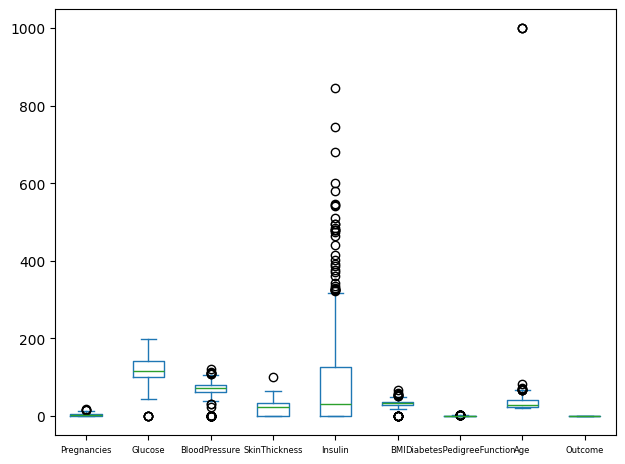

In [8]:
plt.figure(figsize=(8, 8))
df.plot(kind='box')
plt.tight_layout()
plt.xticks(fontsize=6)
plt.show();

상자그림을 통해 변수들을 살펴보면  
Insulin 변수의 값들이 이상값인지 확인해 볼 필요가 있어보이고,  

Age의 999은 이상값 또는 결측값으로 보이고,  
120을 초과하는 값들이 존재한다면 이상값으로 간주할 필요가 있어보인다.  

Glucose, BloodPressure, SkinThickness, BMI의 0 값 또한  
이상값 또는 결측값인지 확인할 필요가 있어보인다.

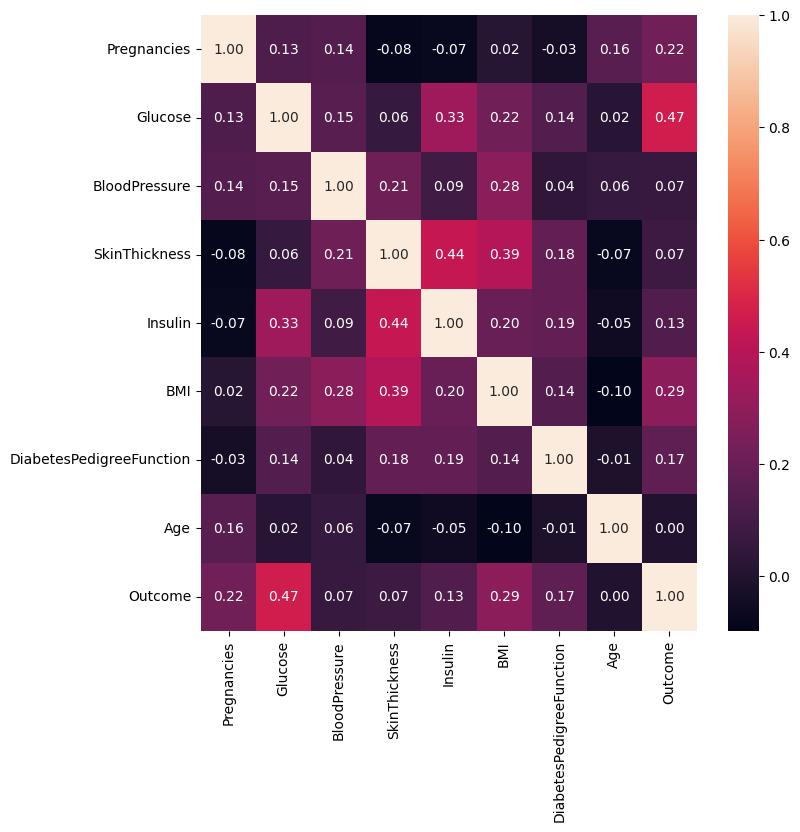

In [9]:
corr_df = df.corr()

plt.figure(figsize=(8, 8))
sns.heatmap(corr_df, annot=True, fmt='.2f')
plt.show();

상관관계 히트맵을 살펴보면   
종속변수와 Glucose 변수와 상관관계가 0.47로 가장 높으며,  
다음으로 BMI, Pregnancies 변수가 차례로 0.29, 0.22이다.

특히 Glucose는 Outcome과 양의 상관관계가 있다고 할 수 있다.  

## 1-2 이상치 식별 및 처리

In [10]:
df[df.Glucose == 0]

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
75,1,0,48,20,0,24.7,0.140,22,0
182,1,0,74,20,23,27.7,0.299,21,0
342,1,0,68,35,0,32.0,0.389,22,0
349,5,0,80,32,0,41.0,0.346,37,1
502,6,0,68,41,0,39.0,0.727,41,1


In [11]:
df[df.BloodPressure == 0]

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
7,10,115,0,0,0,35.3,0.134,29,0
15,7,100,0,0,0,30.0,0.484,32,1
49,7,105,0,0,0,0.0,0.305,24,0
60,2,84,0,0,0,0.0,0.304,21,0
78,0,131,0,0,0,43.2,0.270,26,1
81,2,74,0,0,0,0.0,0.102,22,0
172,2,87,0,23,0,28.9,0.773,25,0
193,11,135,0,0,0,52.3,0.578,40,1
222,7,119,0,0,0,25.2,0.209,37,0
261,3,141,0,0,0,30.0,0.761,27,1


In [12]:
df[df.SkinThickness == 0]

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
2,8,183,64,0,0,23.3,0.672,32,1
5,5,116,74,0,0,25.6,0.201,30,0
7,10,115,0,0,0,35.3,0.134,29,0
9,8,125,96,0,0,0.0,0.232,54,1
10,4,110,92,0,0,37.6,0.191,30,0
...,...,...,...,...,...,...,...,...,...
757,0,123,72,0,0,36.3,0.258,52,1
758,1,106,76,0,0,37.5,0.197,26,0
759,6,190,92,0,0,35.5,0.278,66,1
762,9,89,62,0,0,22.5,0.142,33,0


In [13]:
df[df.BMI == 0]

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
9,8,125,96,0,0,0.0,0.232,54,1
49,7,105,0,0,0,0.0,0.305,24,0
60,2,84,0,0,0,0.0,0.304,21,0
81,2,74,0,0,0,0.0,0.102,22,0
145,0,102,75,23,0,0.0,0.572,21,0
371,0,118,64,23,89,0.0,1.731,21,0
426,0,94,0,0,0,0.0,0.256,25,0
494,3,80,0,0,0,0.0,0.174,22,0
522,6,114,0,0,0,0.0,0.189,26,0
684,5,136,82,0,0,0.0,0.640,999,0


In [14]:
df[df.Insulin == 0]

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
5,5,116,74,0,0,25.6,0.201,30,0
7,10,115,0,0,0,35.3,0.134,29,0
...,...,...,...,...,...,...,...,...,...
761,9,170,74,31,0,44.0,0.403,43,1
762,9,89,62,0,0,22.5,0.142,33,0
764,2,122,70,27,0,36.8,0.340,27,0
766,1,126,60,0,0,30.1,0.349,47,1


Insulin, SkinThickness의 0은 이상값은 아닌 걸로 추측된다.  
그러나 Glucose, BloodPressure, BMI의 0은 이상값  
또는 결측값으로 추측되므로 평균으로 대체하여 처리한다.

In [15]:
for col in ['Glucose', 'BloodPressure', 'BMI']:
    df.loc[df[col] == 0, col] = None
    df.loc[df[col].isna(), col] = df[col].mean()

In [16]:
display(df[df.Glucose == 0])
display(df[df.BloodPressure == 0])
display(df[df.BMI == 0])

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome


In [17]:
df[df.Age >= 100]

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
559,11,85.0,74.0,0,0,30.100000,0.300,999,0
629,4,94.0,65.0,22,0,24.700000,0.148,999,0
684,5,136.0,82.0,0,0,32.457464,0.640,999,0


In [18]:
age_mean = df.Age.mean()
print(age_mean)

36.98046875


In [19]:
df[(df.Pregnancies == 11) & (df.Age != 999)]

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
24,11,143.0,94.000000,33,146,36.6,0.254,51,1
36,11,138.0,76.000000,0,0,33.2,0.420,35,0
193,11,135.0,72.405184,0,0,52.3,0.578,40,1
259,11,155.0,76.000000,28,150,33.3,1.353,51,1
558,11,103.0,68.000000,40,0,46.2,0.126,42,0
590,11,111.0,84.000000,40,0,46.8,0.925,45,1
614,11,138.0,74.000000,26,144,36.1,0.557,50,1
648,11,136.0,84.000000,35,130,28.3,0.260,42,1
658,11,127.0,106.000000,0,0,39.0,0.190,51,0
740,11,120.0,80.000000,37,150,42.3,0.785,48,1


In [20]:
preg_11_mean = df.loc[(df.Pregnancies == 11) & (df.Age != 999), 'Age'].mean()
print(preg_11_mean)

45.5


Age의 경우 999는 결측값으로 보이며,  
559번 데이터의 경우 Pregnancies가 11회 이므로 해당 데이터의 Age 평균을,  
나머지 두 데이터는 Age의 평균으로 대체하여 처리한다.

In [21]:
df.loc[(df.Pregnancies == 11) & (df.Age == 999), 'Age'] = int(preg_11_mean)

In [22]:
df.loc[(df.Pregnancies == 11) & (df.Age == 999), 'Age']

Series([], Name: Age, dtype: int64)

In [23]:
df.loc[df.Age == 999, 'Age']

629    999
684    999
Name: Age, dtype: int64

In [24]:
df.loc[df.Age == 999, 'Age'] = int(age_mean)

In [25]:
df.loc[df.Age == 999]

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome


상자그림의 수염 밖에 있는 Insulin 데이터가 이상값인지 확인한다.

In [26]:
df[df.Insulin >= df.Insulin.quantile(0.75)]

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
4,0,137.0,40.0,35,168,43.1,2.288,33,1
8,2,197.0,70.0,45,543,30.5,0.158,53,1
13,1,189.0,60.0,23,846,30.1,0.398,59,1
14,5,166.0,72.0,19,175,25.8,0.587,51,1
16,0,118.0,84.0,47,230,45.8,0.551,31,1
...,...,...,...,...,...,...,...,...,...
740,11,120.0,80.0,37,150,42.3,0.785,48,1
744,13,153.0,88.0,37,140,40.6,1.174,39,0
748,3,187.0,70.0,22,200,36.4,0.408,36,1
753,0,181.0,88.0,44,510,43.3,0.222,26,1


In [27]:
df[df.Insulin >= df.Insulin.quantile(0.90)]

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
8,2,197.0,70.0,45,543,30.5,0.158,53,1
13,1,189.0,60.0,23,846,30.1,0.398,59,1
16,0,118.0,84.0,47,230,45.8,0.551,31,1
20,3,126.0,88.0,41,235,39.3,0.704,27,0
31,3,158.0,76.0,36,245,31.6,0.851,28,1
...,...,...,...,...,...,...,...,...,...
707,2,127.0,46.0,21,335,34.4,0.176,22,0
710,3,158.0,64.0,13,387,31.2,0.295,24,0
713,0,134.0,58.0,20,291,26.4,0.352,21,0
715,7,187.0,50.0,33,392,33.9,0.826,34,1


In [28]:
df[df.Insulin >= 500]

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
8,2,197.0,70.0,45,543,30.5,0.158,53,1
13,1,189.0,60.0,23,846,30.1,0.398,59,1
228,4,197.0,70.0,39,744,36.7,2.329,31,0
247,0,165.0,90.0,33,680,52.3,0.427,23,0
286,5,155.0,84.0,44,545,38.7,0.619,34,0
409,1,172.0,68.0,49,579,42.4,0.702,28,1
584,8,124.0,76.0,24,600,28.7,0.687,52,1
655,2,155.0,52.0,27,540,38.7,0.240,25,1
753,0,181.0,88.0,44,510,43.3,0.222,26,1


상식적으로 보이지 않을 수 있지만 이상값으로 보기에는  
유사한 값들이 여럿 관측됐기 때문에 수염 밖의 Insulin 값은  
관측값으로 보여진다.

### 1-3 앞 두 단계에서 발견한 향후 분석 시 고려해야 할 사항

당뇨병에 관한 도메인이 부족하기 때문에 관측된 값의 이상 여부를  
판단하는 데 있어 어려움이 따를 수 있다.  

앞서 처리한 이상값을 상식적인 선에서 처리했지만  
관측 당시 실제로는 이상값이 아닐 수 있고,  
또는 결측된 관측값을 임의로 기록한 값일 수 있기 때문에  
데이터를 분석하기 전 반드시 데이터 제공자와의 협의가 필요해 보인다.

또한 Insulin 데이터의 경우 데이터의 분포가 다양하고,  
최대/최소값의 차이가 큰 편이므로 관측값의 정상 범위를 파악하여  
정상/비정상의 이진 변수로 활용하는 방법을 고려할 수 있어 보인다.

그리고 종속변수 Outcome이 다소 불균형하기 때문에  
모델 성능에 영향을 미칠 수 있으므로 샘플링 기법을 통해  
불균형 처리를 고려할 수 있어 보인다.

### 2-1 업 샘플링 과정을 설명하고 결과를 작성

업 샘플링(오버 샘플링)이란, 불균형 클래스를 균형하게 맞추기 위해  
소수의 클래스를 다수의 클래스의 수와 유사하게 맞추는 기법으로,  
일반적으로는 언더 샘플링보다는 모델 학습 때 성능에 유리하다.

Random Oversamping, SMOTE, ADASYN 등의 방식이 존재한다.

In [29]:
from imblearn.over_sampling import SMOTE, RandomOverSampler

In [30]:
smote = SMOTE(sampling_strategy=1, random_state=2025, k_neighbors=5)

In [31]:
x = df.iloc[:, :-1]
y = df[['Outcome']]

In [32]:
y.value_counts()

Outcome
0          500
1          268
Name: count, dtype: int64

In [33]:
samp_x, samp_y = smote.fit_resample(x, y)

In [34]:
samp_y.value_counts()

Outcome
0          500
1          500
Name: count, dtype: int64

오버샘플링 중 SMOTE 기법을 통해 Outcome 변수의  
1 레이블을 500개로 오버샘플링 하였다.

### 2-2 언더 샘플링 과정을 설명하고 결과를 작성

언더 샘플링이란, 불균형 클래스를 균형하게 맞추기 위해  
다수의 클래스 쪽의 데이터를 제거하여 소수의 클래스 수와  
유사하게 맞추는 기법이다. 데이터 불균형 해결은 가능하지만  
전체 데이터의 수가 줄어 과소적합의 원인이 될 수도 있다.

In [35]:
from imblearn.under_sampling import RandomUnderSampler

In [36]:
under = RandomUnderSampler(random_state=2025)

under_samp_x, under_samp_y = under.fit_resample(x, y)

In [37]:
under_samp_y.value_counts()

Outcome
0          268
1          268
Name: count, dtype: int64

언더샘플링을 통해 Outcome 변수의 0 레이블을  
268개로 언더샘플링 하였다.

### 2-3 샘플링 하나를 선택하고, 그 이유 서술

당뇨병 유무와 신체검사 데이터의 데이터 불균형 처리를 위해  
오버샘플링, 그 중에서도 SMOTE 기법을 적용한다.  

그 이유로는 데이터가 1000행 미만으로 데이터셋이 상당히 작아  
언더샘플링을 적용한다면 학습 효율이 떨어질 우려가 있기 때문이다.  

또한 SMOTE 기법은 K-최근접이웃 알고리즘을 통해 유사한 데이터를  
생성해주는 개념의 오버샘플링 기법이기 때문에  
클래스 불균형을 처리하며 동시에 학습 성능에 유리해 보이기 때문이다.

### 3-1 최소 3개 이상의 알고리즘 제시하고
### 정확도 측면의 1개, 속도 측면의 1개 선정

In [38]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

제시할 알고리즘으로 K-최근접이웃, 로지스틱 회귀, 서포트 벡터 머신을 제시한다.  
그중에서 속도 측면의 모델로 로지스틱 회귀 모델을,  
정확도 측면의 모델로는 K-최근접이웃 모델을 선정한다.

### 3-2 모델 비교 및 결과 설명

모델 비교를 진행하기 위한 학습 및 검증은  
2의 오버샘플링된 데이터로 진행한다.  

따라서 samp_x, samp_y 데이터를 7:3 비율로 분할하여 활용한다.

In [39]:
train_x, test_x, train_y, test_y = train_test_split(
    samp_x, samp_y,
    stratify=samp_y,
    test_size=0.3,
    random_state=2025
)

train_x.shape, test_x.shape

((700, 8), (300, 8))

In [40]:
knn = KNeighborsClassifier()
lr = LogisticRegression()
svm = SVC()

In [41]:
for md in [('K-NN', knn), ('Logistic Regression', lr), ("SVM", svm)]:
    start = time.time()
    md[1].fit(train_x, train_y)
    print(f'{md[0]} Score : {md[1].score(test_x, test_y):.3%}')
    end = time.time()
    print(f'Processing Time : {end - start:.3f} sec\n\n')

K-NN Score : 73.000%
Processing Time : 0.019 sec


Logistic Regression Score : 70.667%
Processing Time : 0.040 sec


SVM Score : 70.667%
Processing Time : 0.021 sec




3-1에서 예측한 정확도 측면의 모델은 K-NN 알고리즘이 가장 높은 것을 확인했다.  

그러나 속도 측면에서는 예상과 다르게 SVM, 즉 서포트 벡터 머신 알고리즘이  
가장 높은 모델인 것을 확인했다.

따라서 정확도 측면의 모델로는 K-NN 알고리즘,  
속도 측면의 모델로는 SVM 알고리즘을 활용하는 것이 좋아 보인다.

### 3-3 속도 개선을 위한 차원 축소 방법을 설명하고 수행
### 예측 성능과 속도를 비교하고 결과 작성

차원축소 방법으로는 주성분 분석(PCA), 특이값 분해(SVD), 요인 분석,  
다차원 척도법(MDS) 등이 존재한다.

- PCA : 원 데이터의 특징을 잘 설명하는 성분을 추출해 고차원 공간의  
  표본들을 선형 연관성이 없는 저차원 공간으로 변환하는 기법
- SVD : M × N 차원의 행렬 데이터에서 특이값을 추출해 주어진 데이터셋을 효과적으로 축약
- 요인분석 : 모형을 세운 뒤 관찰 가능한 데이터를 이용하여 해당 잠재 요인을 도출하고,  
  데이터 안의 구조를 해석하는 기법
- MDS : 개체들 사이의 유사성 및 비유사성을 측정하여 2차원 또는 3차원 공간 상에  
  점으로 표현하여 개체 사이의 집단화를 시각적으로 표현하는 분석법

원 데이터에 여러 차원(컬럼)이 존재해도 보통 PCA 기법을 활용하면  
4개 정도의 주성분으로 설명이 되는 경우가 많기 때문에  
속도 개선을 위해 여러 차원축소 방법 중 PCA 기법을 활용한다.

In [42]:
from sklearn.decomposition import PCA

In [43]:
pca = PCA(n_components=2)

In [44]:
transform = pca.fit_transform(samp_x)
transform

array([[-82.49445174,  28.77549717],
       [-88.50627121, -35.91664326],
       [-81.65115789,  61.7579291 ],
       ...,
       [ 88.09025794, -18.15316501],
       [ -0.95634418, -32.02082215],
       [-82.60155766,  29.50529384]])

In [45]:
transform.shape

(1000, 2)

In [46]:
pca.explained_variance_ratio_  

array([0.91332884, 0.05631367])

In [47]:
sum(pca.explained_variance_ratio_)

np.float64(0.9696425117291678)

samp_x 데이터셋 (1000행의 데이터)을 2개의 주성분으로 축소하였고,  
explained_variancce_ratio_ 속성을 통해 주성분 비율을 확인해보니  
2개의 주성분으로 약 96.96%의 데이터를 설명 가능하므로  
차원축소가 잘 이루어졌다고 볼 수 있다.

In [48]:
pca_train_x, pca_test_x, pca_train_y, pca_test_y = train_test_split(
    transform, samp_y, stratify=samp_y,
    test_size=0.3, random_state=2025
)

pca_train_x.shape, pca_test_x.shape

((700, 2), (300, 2))

In [49]:
pca_knn = KNeighborsClassifier()
pca_lr = LogisticRegression()
pca_svm = SVC()

In [50]:
for md in [('K-NN', pca_knn), ('Logistic Regression', pca_lr), ("SVM", pca_svm)]:
    start = time.time()
    md[1].fit(pca_train_x, pca_train_y)
    print(f'{md[0]} Score : {md[1].score(pca_test_x, pca_test_y):.3%}')
    end = time.time()
    print(f'Processing Time : {end - start:.3f} sec\n\n')

K-NN Score : 70.000%
Processing Time : 0.014 sec


Logistic Regression Score : 69.000%
Processing Time : 0.008 sec


SVM Score : 70.333%
Processing Time : 0.013 sec




정확도가 소폭 감소하긴 했으나 학습 및 추론 시간 역시 감소했음을 확인했다.  

예상했던 바와 같이 입력 데이터 차원이 줄었기 때문에 전반적인  
학습 및 추론 시간이 감소했을 것으로 보이는데,  
소폭이긴 하나 정확도가 소폭 감소했기 때문에  

정확도가 중요한 상황이라면 차원축소를 하지 않는 것이 좋아 보이며,  
추가로 초매개변수 튜닝 등을 해주면 높은 정확도의 모델링도
가능할 것으로 보인다.  

하지만 속도가 중요한 상황이라면 차원축소를 통해 개선이 가능하므로  
차원축소와 더불어 초매개변수 튜닝을 하거나  
앙상블 기법을 통해 여러 알고리즘을 비교/통합하여 활용하는 방법  
등으로 정확도 또한 속도와 동시에 개선이 가능해 보인다.

### 4

회사 제품의 금속 재질 함유량의 분산이 1.3을 넘으면 불량이라고 판단한다.  
회사에서는 품질경영팀으로부터 제조사별로 금속 함유량이 차이난다고  
제보받았다. 해당 금속 함유량 데이터에 대한 검정을 수행하시오. (유의확률 0.05)

- (1) 귀무가설, 대립가설 작성
- (2) 가설에 대한 양측검정 수행

### 4-1

- 귀무가설 H0 : 금속 재질 함유량의 분산은 1.3이다.
- 대립가설 H1 : 금속 재질 함유량의 분산은 1.3이 아니다.

### 4-2

정규성 검증을 진행한 후 정규성을 만족한다면 등분산 검정,  
정규성을 불만족한다면 비모수 검정을 진행한다.

#### 정규성 검정
- 귀무가설 H0 : 정규성을 만족한다.
- 대립가설 H1 : 정규성을 불만족한다.

In [51]:
data = pd.read_csv('../Edu/code/data/metalicity.csv')

In [52]:
from scipy import stats

len(data)

150

데이터가 150개이므로 shapiro-wilk 검정을 진행한다.

In [53]:
result = stats.shapiro(data)

In [54]:
print(result.pvalue)
print(result.pvalue > 0.05)

0.05002119086104785
True


P-Value가 0.05 이상이므로 유의수준 5% 하에서 귀무가설을 채택,  
데이터는 정규성을 만족한다. 단일 표본 분산 검정을 진행한다.

In [55]:
n = len(data)
df = n - 1
var_0 = 1.3
var = np.var(data, ddof=1)

chi2_stat = (df * var) / var_0

# 카이제곱 통계량
cdf = stats.chi2.cdf(chi2_stat, df)

# 양측검정
pvalue = 2 * (1 - cdf) if cdf > 0.5 else (2 * cdf)

In [56]:
pvalue[0] > 0.05

np.False_

P-Value가 0.05 이하이므로 유의수준 5% 하에서 귀무가설을 기각하고   
대립가설을 채택, 통계적으로 금속 재질 함유량의 분산은 1.3이 아니다.

### 5

제품 200개의 Lot별 불량 제품 수량 데이터에 대해 p관리도를 구하고 시각화

- (1) p관리도에 따라 관리중심선, 관리상한선, 하한선 구하기
- (2) 관리도 시각화

### 5-1

In [57]:
data = pd.read_csv('../Edu/code/data/lot_quality.csv')
data.head()

,lot,생산수량,불량수량
0,1,587,19
1,2,588,15
2,3,455,19
3,4,666,12
4,5,750,15


In [58]:
data['p'] = data.불량수량 / data.생산수량

In [59]:
data['ucl'] = data['p'] + 3 * np.sqrt( data['p'] * (1 - data['p']) / data.생산수량)
data['lcl'] = data['p'] - 3 * np.sqrt( data['p'] * (1 - data['p']) / data.생산수량)

In [60]:
cl = data.불량수량.sum() / data.생산수량.sum()

In [61]:
cl

np.float64(0.029024320840935338)

데이터의 관리중심선은 약 0.029이다.
관리상한선(ucl 컬럼), 관리하한선(lcl 컬럼)은 각각 아래와 같다.

In [62]:
data[['p', 'ucl', 'lcl']]

,p,ucl,lcl
0,0.032368,0.054282,0.010454
1,0.025510,0.045017,0.006004
2,0.041758,0.069892,0.013625
3,0.018018,0.033481,0.002555
4,0.020000,0.035336,0.004664
...,...,...,...
195,0.028526,0.048407,0.008645
196,0.037168,0.061044,0.013292
197,0.021053,0.039092,0.003013
198,0.019342,0.037514,0.001171


### 5-2

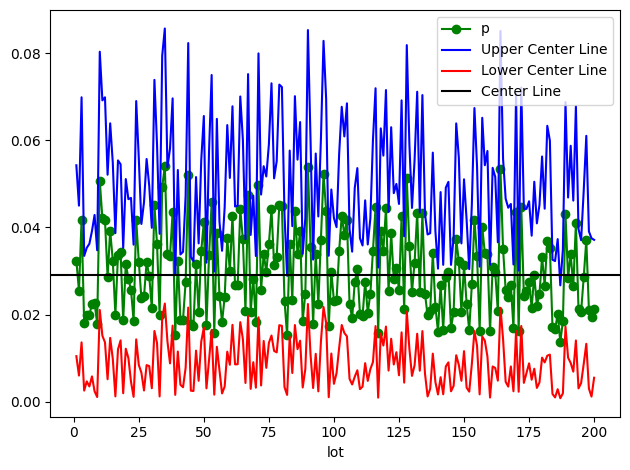

In [63]:
plt.plot(data['lot'], data['p'], label='p', marker='o', color='g')
plt.plot(data['lot'], data['ucl'], label='Upper Center Line', color='b')
plt.plot(data['lot'], data['lcl'], label='Lower Center Line', color='r')
plt.axhline(cl, color='black', label='Center Line')
plt.xlabel('lot')
plt.legend()
plt.tight_layout()
plt.show();

### 6

제품 1, 2를 만드는 데 재료 a, b, c가 일부 사용되며, 제품 1과 2를 만들 때,  
12만원과 18만원을 벌 수 있다. 재료는 한정적일 때, 최대 수익을 낼 수 있을  
때의 제품 1과 제품 2의 개수를 구하라.

재료공급량 {'a' : 1300, 'b' : 1000, 'c' : 1200}

In [64]:
data_dict = {'a':[20, 40], 'b':[20, 30], 'c':[20, 30]}
data = pd.DataFrame(data_dict, index=['제품1', '제품2'])
data

,a,b,c
제품1,20,20,20
제품2,40,30,30


In [65]:
a = 1300
b = 1000
c = 1200

prod1_cnt = 0
prod2_cnt = 0

max_prod2_cnt = 32
max_a, max_b, max_c = 20, 40, 240

max_profit = 32 * 18

while max_a > 0 or max_b > 0 or max_c > 0:
    max_prod2_cnt -= 1
    max_a += 40
    max_b += 30
    max_c += 30

    while max_a >= 20 and max_b >= 20 and max_c >= 20:
            
        max_a -= 20
        max_b -= 20
        max_c -= 20
    
        prod1_cnt += 1
        
        if max_prod2_cnt * 18 + prod1_cnt * 12 > max_profit:
            max_profit = max_prod2_cnt * 18 + prod1_cnt * 12
            result_prod1 = prod1_cnt
            result_prod2 = max_prod2_cnt
    
    if max_prod2_cnt == 0:
        break

In [66]:
print(f'최대 수익 : {max_profit}')
print(f'제품 1 : {result_prod1}개')
print(f'제품 2 : {result_prod2}개')

최대 수익 : 600
제품 1 : 5개
제품 2 : 30개


### 7

상품 a와 b가 있을 때 다음과 같은 구매 패턴이 있다고 한다.

a, a, b, b, a, a, a, a, b, b, b, b, b, a, a, b, b, a, b, b

- (1) 구매 패턴으로 볼 때 두 상품이 연관이 있는지 가설을 세우고 검정
- (2) 가설 채택

In [67]:
pattern = ['a', 'a', 'b', 'b', 'a', 'a', 'a', 'a', 'b', 'b',
           'b', 'b', 'b', 'a', 'a', 'b', 'b', 'a', 'b', 'b']

### 7-1

- 귀무가설 H0 : 두 상품은 연관이 없다.
- 대립가설 H1 : 두 상품은 연관이 있다.

두 상품의 연관성을 확인하기 위해 Run Test를 진행한다.

In [68]:
from statsmodels.sandbox.stats.runs import runstest_1samp

In [69]:
z_stat, pvalue = runstest_1samp(list(map(lambda x: 0 if x == 'a' else 1, pattern)))

In [70]:
print(f'검정통계량 : {z_stat:.4f}\nP-Value : {pvalue:.4f}')

검정통계량 : -1.1145
P-Value : 0.2651


In [71]:
pvalue > 0.05

np.True_

### 7-2

P-Value가 0.05 초과하므로 유의수준 5% 하에서 귀무가설을 채택,  
통계적으로 두 상품은 연관이 없다.

                                        마지막 20 페이지. 끝.